# Playing with Google Trends and LOESS

A friend and I had a debate about whether people were drinking more or less now in COVID times. We couldn't resolve, so I made a quick little notebook that uses Google Trends to look at seasonality and trends in the data and to identify possible anonmalies.

In [1]:
import pandas as pd
from pytrends.request import TrendReq
import datetime
from dateutil.relativedelta import relativedelta
import time
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def plot(original_series, trend=None, seasonal=None, resid=None, upper=None, lower=None, label='metric',
         anomalies_low=None, anomalies_high=None):

    fig = plt.figure(figsize=(15,15))
    
    plt.subplot(4,1,1)
    plt.plot(original_series)
    first_date = original_series.index.min()
    last_date = original_series.index.max()
    num_months = (last_date.year - first_date.year) * 12 + (last_date.month - first_date.month)
    
    for x in range(0,num_months):
        tmp = (last_date - relativedelta(months=x)).replace(day=1)
        plt.axvline(tmp, color='k', linestyle='--', alpha=0.5)
        if tmp <= first_date:
            break

    if anomalies_low is not None:
        plt.scatter(anomalies_low.index, anomalies_low.values, color='blue', marker='D')
    if anomalies_high is not None:
        plt.scatter(anomalies_high.index, anomalies_high.values, color='salmon', marker='D')
    
    plt.title(f'Original Series: {label}', fontsize=16)    
    ax = fig.axes[0]
    
    x = 2
    if trend is not None:
        plt.subplot(4,1,x, sharex=ax)
        plt.plot(trend)
        plt.title('Trend', fontsize=16)
        x = x+1
    
    if seasonal is not None:
        plt.subplot(4,1,x, sharex=ax)
        plt.plot(seasonal)
        plt.title('Seasonal', fontsize=16)
        x = x+1

    if resid is not None:
        plt.subplot(4,1,x, sharex=ax)
        plt.plot(resid)
        if upper is not None and lower is not None:
            plt.fill_between([original_series.index.values.min(), original_series.index.values.max()], 
                             lower, upper, color='green', alpha=0.1, linestyle='--', linewidth=2)
            plt.xlim(original_series.index.values.min(), original_series.index.values.max())
            plt.title('Residual', fontsize=16)

    plt.tight_layout()
    plt.show()



In a quick search, I could not find multi-year, up-to-date alcohol sales, but we can use a proxy.  I will look at Google Trends data to look at the interest in hangover cures as a proxy for alcohol consumption.

In [2]:
kw_list = ["hangover cure"]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
df = pytrends.interest_over_time()
df.head()

,hangover cure,isPartial
date,,
2015-09-06,42,False
2015-09-13,38,False
2015-09-20,41,False
2015-09-27,35,False
2015-10-04,40,False


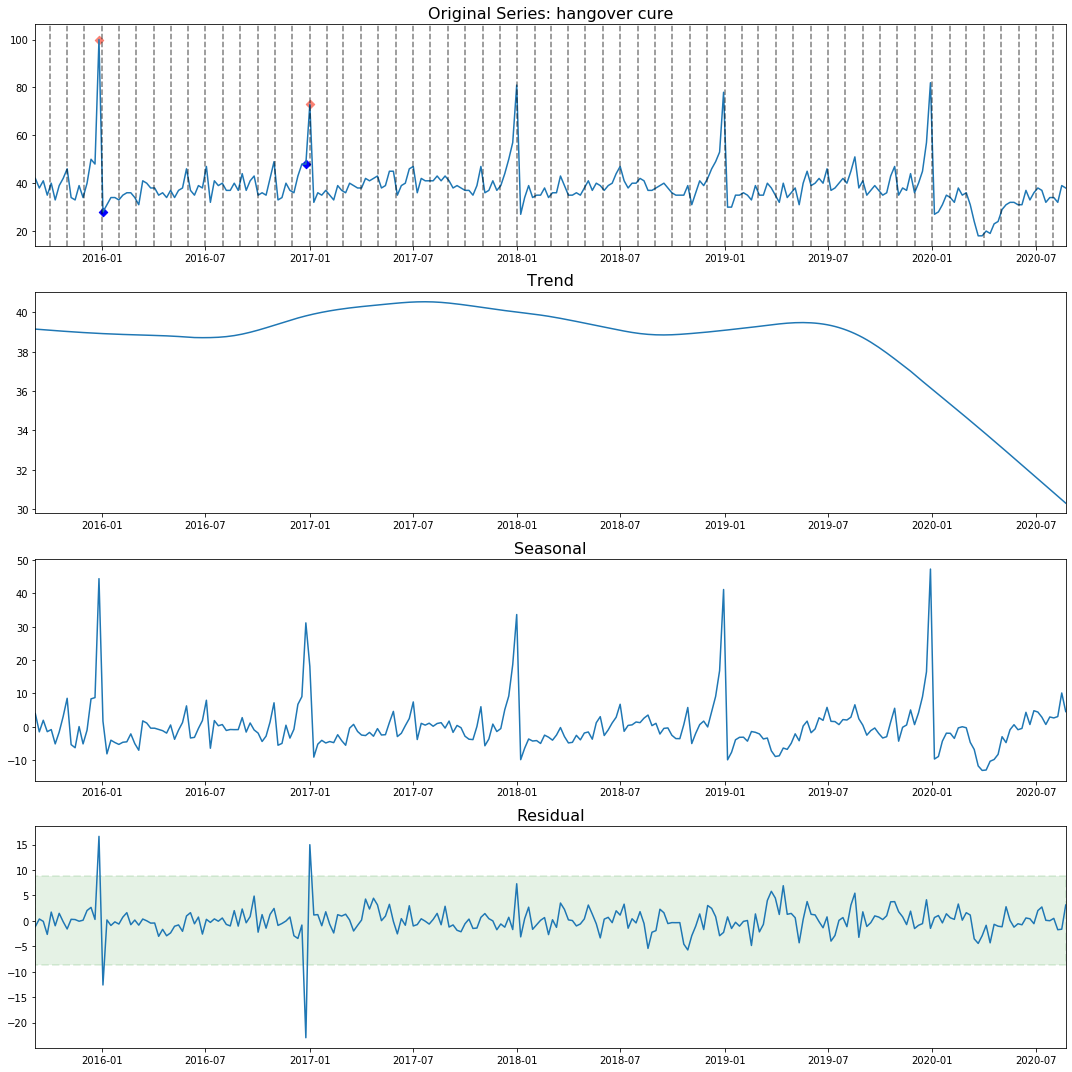

In [3]:
for column in kw_list:
    original_series = df[df.isPartial == 'False'][[column]].copy()

    stl = STL(original_series, robust=False)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid

    resid_mu = resid.mean()
    resid_dev = resid.std()

    lower = resid_mu - 3*resid_dev
    upper = resid_mu + 3*resid_dev

    anomalies_low = original_series[(resid < lower)]
    anomalies_high = original_series[(resid > upper)]

    plot(original_series, trend=trend, seasonal=seasonal, resid=resid, upper=upper, lower=lower, label=column,
        anomalies_low=anomalies_low, anomalies_high=anomalies_high)

I am using 3 standard deviations of the residual to find potential anomalies in the data.  I plot the points
outside of this range as anomalies (red for high, blue for low).

**Observations**

The interest in hangover cures has gone down in 2020. The dip coincides with Corona virus lockdowns in most US states, so it is a fair assumption that this had a clear impact. There was a rebound after some of the lockdowns were lifted, but not to it's full amount. Using interest in hangover cures as a proxy for alcohol consumption, would indicate that we are drinking less. Perhaps drinking alone at home or socially distant isn't for everyone or perhaps fiscal crisis means less money for alcohol. To be continued...

People in the US look for hangover cures in the last week of the year, basically Christmas to New Years... no surprise there.
- 2015 stands as being particuarly high, so high there was dryer than exepected period directly afterwards. New Year's resolutions after a particularly festive holiday period?
- 2016 had a severely low point and high point. Trump effect?

